## Replication of Keller et al. (2026) on the TRAPPIST-1 Case
A study on how higher-order resonances can form in just Type I migration.

#### Imports and Units

In [ ]:
import re
import rebound
import reboundx
import numpy as np
import pandas as pd
import pickle
import scipy
import matplotlib.pyplot as plt
from time import time
from astropy import constants as const
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')

# Unit conversions
AU = u.AU.to(u.cm)    
Msun = u.Msun.to(u.g) 
yr = u.yr.to(u.s)    
r_earth = u.earthRad.to(u.AU)
m_earth = u.Mearth.to(u.Msun)
r_sun = u.Rsun.to(u.AU) 

#### Randomly generate mass, radius, & semimajor axis values
Planetary parameters taken from the NASA Exoplanet Archive, based on Agol 2021.

In [85]:
def parse_entry(entry):
    """
    Parses strings of form:
        '1.0±0.01'
        '1.04 +0.01 -0.02'
    
    Returns:
        mu (float), sigma (float)
    """
    
    if pd.isna(entry):
        raise ValueError("Entry is NaN")
    
    # Remove extra whitespace
    entry = entry.strip()
    
    # Remove spaces for easier parsing
    entry_nospace = entry.replace(" ", "")
    
    # Case 1: symmetric uncertainty (±)
    match_pm = re.match(r"^([0-9.+\-eE]+)±([0-9.+\-eE]+)$", entry_nospace)
    if match_pm:
        mu = float(match_pm.group(1))
        sigma = float(match_pm.group(2))
        return mu, sigma
    
    # Case 2: asymmetric uncertainty (+x -y)
    match_asym = re.match(
        r"^([0-9.+\-eE]+)\+([0-9.+\-eE]+)\-([0-9.+\-eE]+)$",
        entry_nospace
    )
    if match_asym:
        mu = float(match_asym.group(1))
        sigma_plus = float(match_asym.group(2))
        sigma_minus = float(match_asym.group(3))
        
        # Convert asymmetric → effective symmetric σ
        sigma = 0.5 * (sigma_plus + sigma_minus)
        
        return mu, sigma
    
    raise ValueError(f"Could not parse entry: {entry}")

def generate_params(csv_file, params, n_samples=1):
    """
    Reads planet parameter CSV and returns Monte Carlo samples
    for mass, radius, and semimajor axis.
    """
    
    df = pd.read_csv(csv_file)
    
    # Set index to Source column for easy lookup
    df = df.set_index("Source")
    
    # Extract Agol et al. 2021 column
    col = "Agol et al. 2021"
    
    params_dict = {}
    
    for param in params:
        # Parse parameter
        mu, sigma = parse_entry(df.loc[param, col])
    
        # Draw Gaussian samples
        samples  = np.random.normal(mu,  sigma,  n_samples)

        # Add to dict
        params_dict[param] = samples
    
    return params_dict

planet_names = ['b', 'c', 'd', 'e', 'f', 'g', 'h']
# Nested dict containing params for each planet in sim
planet_params = {f"{planet_name}": generate_params(f'TRAPPIST-1_params/TRAPPIST-1_{planet_name}_planet_params.csv', ('a (au)', 'Rp (R⨁)', 'Mp (M⨁)')) for planet_name in planet_names}
stellar_params = generate_params('TRAPPIST-1_params/TRAPPIST-1_stellar_params.csv', ('R✶ (R⦿)', 'M✶ (M⦿)'))

#### Sim Setup

In [86]:
# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"
sim.random_seed = 13741154 # for reproducibility

# Add the star
m_star = stellar_params['M✶ (M⦿)']
r_star = stellar_params['R✶ (R⦿)'] * r_sun
sim.add(m=m_star, r=r_star)

num_planets = len(planet_names)

# Define planet masses (m)
m_vals = np.array([planet_params[planet_name]['Mp (M⨁)'] for planet_name in planet_names])
m_vals *= m_earth # convert to Msun

# Define planet radii (r)
r_vals = np.array([planet_params[planet_name]['Rp (R⨁)'] for planet_name in planet_names])
r_vals *= r_earth # convert to AU

# Define initial eccentricities (e)
e_vals = np.zeros_like(m_vals)

# Draw initial mean anomalies (M)
M_vals = np.random.uniform(0, 2*np.pi, size=num_planets)

# Initial semimajor axis of b
a_b = 0.1 

# Draw initial ratios from log normal
initial_P_ratios = np.random.lognormal(0.45, 0.1, size=num_planets-1) 
                                     # In Keller, 0.703 & 0.313

# Define initial periods (P) and semimajor axes (a)
P_vals = (a_b**3 / m_star)**(1/2)
for i in range(num_planets-1):
    P_vals = np.append(P_vals, P_vals[i] * initial_P_ratios[0])
    
a_vals = (P_vals**2 * m_star)**(1/3)

print("Initial period ratios:")
print(np.round(initial_P_ratios, decimals=4))
print("\nInitial period values (yr):")
print(np.round(P_vals, decimals=4))
print("\nInitial semimajor axis values (AU):")
print(np.round(a_vals, decimals=4))

# Add planets 
for i in range(num_planets):
    sim.add(m=m_vals[i], r=r_vals[i], a=a_vals[i], e=e_vals[i], M=M_vals[i])

# Move to center of momentum
sim.move_to_com()
ps = sim.particles
planets = ps[1:] # for easier indexing

Initial period ratios:
[1.3767 1.5906 1.6249 1.7517 1.579  1.8423]

Initial period values (yr):
[0.1026 0.1412 0.1944 0.2677 0.3685 0.5074 0.6985]

Initial semimajor axis values (AU):
[0.1    0.1238 0.1532 0.1895 0.2346 0.2903 0.3592]


#### Sim Params
Based on section 2.1 in Keller et al. (2026).

In [87]:
def get_taus(a_vals, m_vals, M_star, h, Sigma, alpha=1.5):
    '''
    Computes damping timescales based on current semimajor axis values.
    
    Parameters:
        a_vals: 1D NumPy array of current semimajor axis values.
    
    Returns:
        tau_a: semimajor axis damping timescale.
        tau_e: eccentricity damping timescale.
    '''
    tau_a = (1/(2.7+1.1*alpha)) * (M_star/m_vals) * (M_star/(Sigma*a_vals**2)) * (h**2 / np.sqrt(const.G.value*M_star/a_vals**3))
    tau_e = (1/0.780) * (M_star/m_vals) * (M_star/(Sigma*a_vals**2)) * (h**4 / np.sqrt(const.G.value*M_star/a_vals**3))
    return tau_a, tau_e

def get_Sigma(a_vals, Sigma_1au, alpha=1.5):
    return Sigma_1au * a_vals**(-alpha)

def get_h(K, alpha=1.5):
    return np.sqrt(0.780/(2.7+1.1*alpha)/K)

def get_Sigma(Sigma_1au, a_vals, alpha=1.5):
    return Sigma_1au * (a_vals**-alpha)

# Draw surface density at 1au from log uniform
Sigma_1au = scipy.stats.loguniform.rvs(a=10, b=10000, size=1) # in g/cm^2
Sigma_1au *= AU**2 / Msun # unit conversion for sim
print(f"Sigma_1au: {float(Sigma_1au):.3e}")

# Draw K-factor from log uniform and solve for h
K = scipy.stats.loguniform.rvs(a=50, b=500, size=1)
                             # In Keller, 10 & 1000
h = get_h(K) # here, h = h_1au since there is no flaring
print(f"h_1au: {float(h):.4g}")
print(f"tau_a of b: {float(get_taus(a_b, m_vals, m_star, h, get_Sigma(Sigma_1au, a_b))[0][0]):.3e}")

Sigma_1au: 4.906e-04
h_1au: 0.0372
tau_a of b: 5.258e+07


#### Handling Close Encounters
Symplectic integrators are not designed to handle close encounters, so we discard sims where planets ventured within five mutual Hill radii of each other.

In [88]:
def get_hill_radius(m1, a1, m2, a2, M_star):
    return ((m1+m2)/(3*M_star))**1/3 * (a1+a2)/2

#### Implementing REBOUNDx forces
There are several options for the location and width of the inner disk edge (IDE).
- Keller et al. (2026) used 0.05 as the position and 0.01 as the width.
- Huang & Ormel (2022) used positions $r_c \in [0.013 - 0.030 \text{ au}]$ with width $\Delta = 2hr_c = 0.06r_c$. In particular, $r_c = 0.023$ worked best.

In [89]:
rebx = reboundx.Extras(sim)
mig = rebx.load_force("type_I_migration")
rebx.add_force(mig)

mig.params["tIm_scale_height_1"] = h # = h_1au
mig.params["tIm_surface_density_1"] = Sigma_1au
mig.params["tIm_surface_density_exponent"] = 1.5 # alpha
mig.params["tIm_flaring_index"] = 0 # beta

mig.params["ide_position"] = 0.023 # inner disk edge
mig.params["ide_width"] = 2*h*mig.params["ide_position"]

#### Data storage

In [90]:
sim.dt = planets[0].P / 20 # 1/20 of planet b

def data_df(n_out, times):        
    return pd.DataFrame({
        "time": times,
        "a": np.zeros(n_out),
        "e": np.zeros(n_out),
        "P": np.zeros(n_out),
        "P_ratio": np.zeros(n_out),
        "l": np.zeros(n_out),
        "pomega": np.zeros(n_out)
    })

# Set up times for integration & data collection
stage1_end = 1000 # yrs
n_out = int(stage1_end / 10) + 1000 # number of data points to collect; >1 every 10 years

stage1_times = np.linspace(0, stage1_end, n_out)  # all times to integrate over
stage1_data = {name : data_df(n_out, stage1_times) for name in planet_names[:num_planets]}

#### It's time to integrate

In [91]:
tstart = time()
stop_sim = False

for i, t in enumerate(stage1_times):  
    sim.integrate(t)
    
    current_a_vals = np.array([p.a for p in sim.particles[1:]])
    
    for p in range(num_planets):
        name = planet_names[p]
        stage1_data[name]["a"][i] = planets[p].a
        stage1_data[name]["e"][i] = planets[p].e
        stage1_data[name]["l"][i] = planets[p].l
        stage1_data[name]["pomega"][i] = planets[p].pomega
        
        if p != num_planets-1: # don't record period ratio for last planet
            stage1_data[name]["P_ratio"][i] = planets[p+1].P / planets[p].P
                            
            # Stop sim if within 5*r_hill
            r_hill = get_hill_radius(m_vals[p], current_a_vals[p], m_vals[p+1], current_a_vals[p+1], m_star)
            d = np.linalg.norm([planets[p].x - planets[p+1].x, planets[p].y - planets[p+1].y, planets[p].z - planets[p+1].z])
            if d < 5*r_hill:
                stop_sim = True
                print("Close encounter")
            
        # Stop sim if planet goes into star
        if planets[p].a < 0.001:
            stop_sim = True
            print("Planet collided with star")
    
    # Debugging
    print(i, stage1_data['b']["a"][i])
    
    if stop_sim:
        print(f"Stopped integration at t={t}")
        break
        
print(f'finished integration in {time()-tstart:.4} sec')

0 0.10000000000000005
1 0.09865856923468276
2 0.0973444191657198
3 0.09602303110513308
4 0.09467961698904877
5 0.09335836475904911
6 0.09203357478351139
7 0.09070167367987061
8 0.08940559670543646
9 0.08805506556068357
10 0.08672661685316867
11 0.08540486015150747
12 0.08407711577796005
13 0.08278293718443117
14 0.08143077574020877
15 0.08010542513641561
16 0.07877608329331272
17 0.07745373730917257
18 0.07612115587114394
19 0.07479258631451982
20 0.0734705084506948
21 0.07213993081505286
22 0.07081261305201418
23 0.0694840437504936
24 0.06815155350973344
25 0.06682587311811201
26 0.06549393160727207
27 0.06416823641982372
28 0.06284775095012723
29 0.061515264759622074
30 0.06017937117793782
31 0.05885811850363142
32 0.057523225813048376
33 0.05620157237699164
34 0.05486748273372655
35 0.05354870680365759
36 0.05221798439182429
37 0.05089441759571176
38 0.04956784113675773
39 0.04824244155035159
40 0.046918317138299914
41 0.04558538602444908
42 0.04425597383928678
43 0.0429264708807997

#### Plot it!

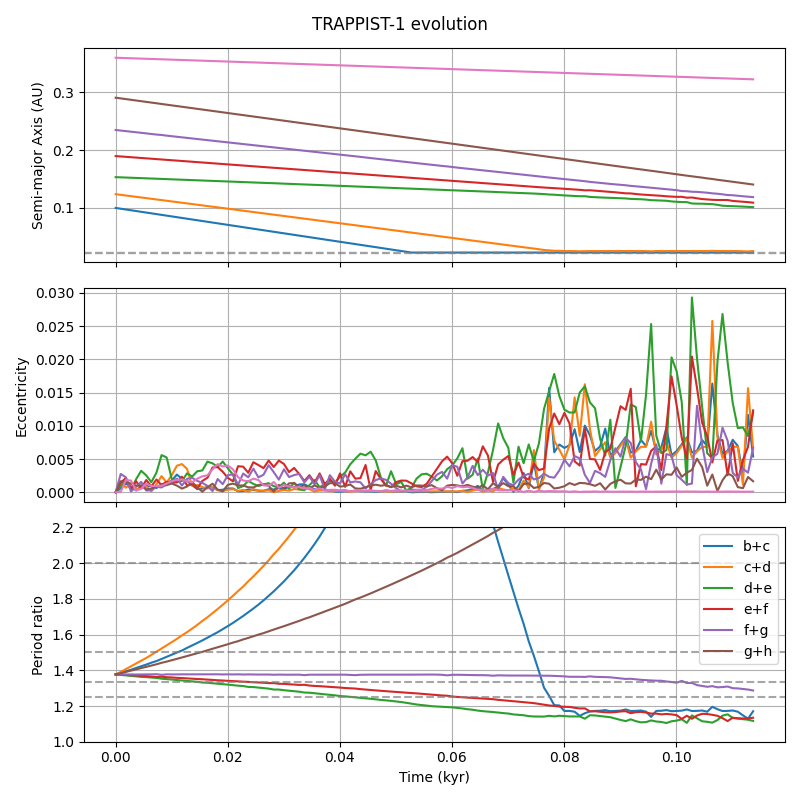

In [92]:
%matplotlib widget

def plot_trappist1():
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    fig.set_figwidth(8)
    fig.set_figheight(8)

    for p in range(num_planets):
        # could also try plotting log
        name = planet_names[p]
        ax1.plot(stage1_times/1000, stage1_data[name]["a"], label=name)
        ax2.plot(stage1_times/1000, stage1_data[name]["e"], label=name)
        if p != num_planets-1:
            ax3.plot(stage1_times/1000, stage1_data[name]["P_ratio"], label=f"{name}+{planet_names[p+1]}")
            
    plt.xlabel("Time (kyr)")
    ax1.set_ylabel("Semi-major Axis (AU)")
    ax2.set_ylabel("Eccentricity")
    ax3.set_ylabel("Period ratio")
    
    # ax1.set_ylim(0,0.45)
    # ax2.set_ylim(-0.1,0.45)
    ax3.set_ylim(1,2.2)
    
    # Plot ide location & width
    ax1.axhline(mig.params["ide_position"], color='gray', ls='--', alpha=0.7)
    ax1.axhline(mig.params["ide_position"] - mig.params["ide_width"], color='gray', ls='--', alpha=0.1)
    ax1.axhline(mig.params["ide_position"] + mig.params["ide_width"], color='gray', ls='--', alpha=0.1)


    # Add horizontal lines for resonances
    resonances = [2, 3/2, 4/3, 5/4]
    for r in resonances:
        ax3.axhline(r, color='gray', ls='--', alpha=0.7)
        
    fig.subplots_adjust(hspace=0)

    plt.suptitle("TRAPPIST-1 evolution")
    ax1.grid(True); ax2.grid(True); ax3.grid(True); # ax4.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()

plot_trappist1()

#### Identifying MMRs
Based on section 2.3 in Keller et al. (2026).

In [ ]:
def find_best_pq(b_name, c_name, p_max=10, q_max=10):
    '''Finds the best values for p and q at the end of simulation for two planets'''
    b, c = stage1_data[b_name], stage1_data[c_name]
    best_Delta = 100
    best_p, best_q = 100, 100
    
    for p in range(1, p_max+1):
        for q in range(1, p):
            # Use Kepler's law to find period values
            P_b = (b['a'].iloc[-1]**3 / m_star)**(1/2)
            P_c = (c['a'].iloc[-1]**3 / m_star)**(1/2)
            Delta = (P_c/P_b)/(p/q) - 1
            
            if np.abs(Delta) < np.abs(best_Delta):
                best_Delta = Delta
                best_p, best_q = p, q
    
    return best_p, best_q

with open("fg_library.pkl", "rb") as f:
    fg_lib = pickle.load(f)
    
def twoBR_angle(b_name, c_name, p, q):
    b, c = stage1_data[b_name], stage1_data[c_name]
    f, g = fg_lib[(p, q)]
    pomega_hat = np.arctan((f*b['e']*np.sin(b['pomega']) + g*c['e']*np.sin(c['pomega'])) / (f*b['e']*np.cos(b['pomega']) + g*c['e']*np.cos(c['pomega'])))
    return q*b['l'] - p*c['l'] + (p-q)*pomega_hat

In [ ]:
# Calculate two-body resonant angle between b and c
p, q = find_best_pq('b', 'c')

assert p != 100 # if not, then the planets are definitely not in resonance
print(f"p, q: {p}, {q}")
print(f"True ratio: {float((stage1_data['c']['a'].iloc[-1]**3 / m_star)**(1/2) / (stage1_data['b']['a'].iloc[-1]**3 / m_star)**(1/2)):.4f}")

twoBR = np.rad2deg(twoBR_angle('b', 'c', p, q))

# Function to center at 180 (so y runs from 0 to 360)
def wrap180(angle):
    return (angle + 180) % 360 - 180

plt.figure(figsize=(8,4))
plt.plot(stage1_times/1000, wrap180(twoBR) + 180, lw=1)
plt.axhline(180, color='gray', ls='--', alpha=0.7)
plt.xlabel("Time (yrs)")
plt.ylabel("Two-body resonant angle $\phi$ (degrees)")
plt.ylim(0,360)
plt.grid(True)
plt.show()

p, q: 100, 100
True ratio: nan


KeyError: (100, 100)